## 1. Importing Libraries and Dataset

#### 1.1 Importing Libraries

In [431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, GridSearchCV

#### 1.2 Loading Dataset

In [432]:
df_train = pd.read_csv("titanic/train.csv")
df_test = pd.read_csv("titanic/test.csv")

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Feature Engineering

Firstly i want to check, how many examples of Survived/Not Survived data are there in the training DataSet

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Survived', ylabel='count'>

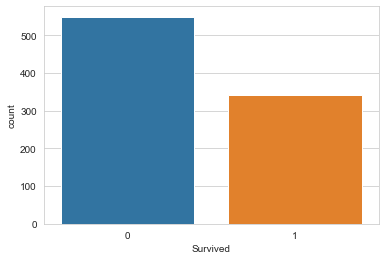

In [433]:
sns.countplot(df_train.Survived)

In [434]:
print(f"Survived - {df_train.Survived.loc[df_train.Survived == 1].count()}, Not Survived - {df_train.Survived.loc[df_train.Survived == 0].count()}")

Survived - 342, Not Survived - 549


There are enough instances of both cases

Let's check how many Categorical/Numerical features do we have

In [435]:
NumericalData = len(df_train.select_dtypes('number').columns)
CategoricalData = len(df_train.select_dtypes(exclude='number').columns)

print(f"Numerical Features - {NumericalData}, Categorical Features - {CategoricalData}")

Numerical Features - 7, Categorical Features - 5


#### 2.1 Missing Values Handling

In [436]:
train_null = df_train.isna().sum()
test_null = df_test.isna().sum()
missing = pd.DataFrame(
              data=[train_null, train_null/df_train.shape[0]*100,
                    test_null, test_null/df_test.shape[0]*100],
              columns=df_train.columns,
              index=["Train Null", "Train Null (%)", "Test Null", "Test Null (%)"]
          ).T.sort_values(["Train Null", "Test Null"], ascending=False)

In [437]:
# Filter only columns with missing values
missing = missing.loc[(missing["Train Null"] > 0) | (missing["Test Null"] > 0)]
missing

,Train Null,Train Null (%),Test Null,Test Null (%)
Cabin,687.0,77.104377,327.0,78.229665
Age,177.0,19.865320,86.0,20.574163
Embarked,2.0,0.224467,0.0,0.000000
Fare,0.0,0.000000,1.0,0.239234


There are a lot of missing values in Cabin and Age, let's handle it

For feature Cabin, 77% of the data is NaN, so I've decided to delete this column

In [438]:
df_train = df_train.drop(columns=["Cabin"])
df_test = df_test.drop(columns=["Cabin"])

There is one missing value for feature "Fare" in the Test Set. I'm going to replace it by median value

In [439]:
df_test.Fare.fillna(df_test.Fare.median(), inplace=True)

There are 2 missing values in the training DataSet, so I just simply delete these two records

In [440]:
df_train = df_train.dropna(subset=["Embarked"])

Now let's deal with the feature "Age". It would be reasonable to look at Age distribution depending on their ticket class.

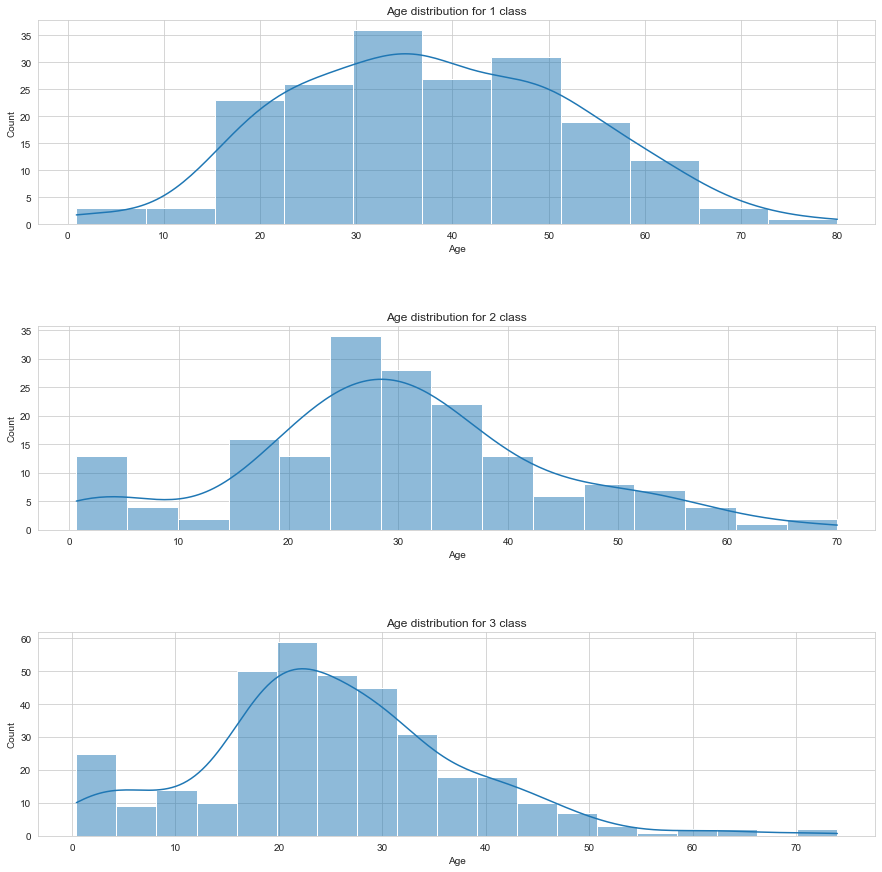

In [441]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
ax = ax.flatten()

for i in range(3):

    sns.histplot(data=df_train.Age.loc[(df_train.Age.isna()==False) & (df_train.Pclass==i+1)], kde=True, ax=ax[i])
    ax[i].set_title(f"Age distribution for {i+1} class")

plt.subplots_adjust(hspace=0.5)
plt.show()

As we can see, the data is skewed to right, so I'll replace missing values in Age by the median depending on ticket class of a passenger.

Replacing missing values for training DataSet

In [442]:
first_class_mean = df_train.loc[df_train.Pclass == 1].Age.median()
second_class_mean = df_train.loc[df_train.Pclass == 2].Age.median()
third_class_mean = df_train.loc[df_train.Pclass == 3].Age.median()

In [443]:
df_train.Age.loc[df_train.Pclass == 1] = df_train.Age.loc[df_train.Pclass == 1].fillna(first_class_mean)
df_train.Age.loc[df_train.Pclass == 2] = df_train.Age.loc[df_train.Pclass == 2].fillna(second_class_mean)
df_train.Age.loc[df_train.Pclass == 3] = df_train.Age.loc[df_train.Pclass == 3].fillna(third_class_mean)

/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_48047/1743752295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.Age.loc[df_train.Pclass == 2] = df_train.Age.loc[df_train.Pclass == 2].fillna(second_class_mean)
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_48047/1743752295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.Age.loc[df_train.Pclass == 3] = df_train.Age.loc[df_train.Pclass == 3].fillna(third_class_mean)


Replacing missing values for testing DataSet

In [444]:
first_class_mean = df_test.loc[df_test.Pclass == 1].Age.median()
second_class_mean = df_test.loc[df_test.Pclass == 2].Age.median()
third_class_mean = df_test.loc[df_test.Pclass == 3].Age.median()

In [445]:
df_test.Age.loc[df_test.Pclass == 1] = df_test.Age.loc[df_test.Pclass == 1].fillna(first_class_mean)
df_test.Age.loc[df_test.Pclass == 2] = df_test.Age.loc[df_test.Pclass == 2].fillna(second_class_mean)
df_test.Age.loc[df_test.Pclass == 3] = df_test.Age.loc[df_test.Pclass == 3].fillna(third_class_mean)

/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_48047/1964673118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.Age.loc[df_test.Pclass == 1] = df_test.Age.loc[df_test.Pclass == 1].fillna(first_class_mean)
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_48047/1964673118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.Age.loc[df_test.Pclass == 2] = df_test.Age.loc[df_test.Pclass == 2].fillna(second_class_mean)
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_48047/1964673118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

#### 2.2 Categorical Variable Encoding

Categorical variables need to be converted into numerical format so that the data with converted categorical values can be provided to the predictive models. There are two types of categorical variable, which is nominal and ordinal. Nominal variable has no intrinsic ordering to its categories, while ordinal variable has a clear ordering. There are different ways to encode these variables depending on their data type. Let's check our categorical variable values first.

In [446]:
# Get variable names and number of unique values
cat_var = df_train.loc[:, df_train.dtypes == "object"].nunique()
# Get variable names
num_var = df_train.loc[:, df_train.dtypes != "object"].columns

In [447]:
# Count sorted unique values (alphabetically) for each categorical variable
cat_var_unique = {var: sorted(df_train[var].unique()) for var in cat_var.index}

# Add "-" for each values to replace none in the DataFrame (889 is highest len of unique values)
for key, val in cat_var_unique.items():
    cat_var_unique[key] += ["-" for x in range(889-len(val))]

pd.DataFrame.from_dict(cat_var_unique, orient="index").sort_values([x for x in range(889)])

,0,1,2,3,4,5,6,7,8,9,...,879,880,881,882,883,884,885,886,887,888
Ticket,110152,110413,110465,110564,110813,111240,111320,111361,111369,111426,...,-,-,-,-,-,-,-,-,-,-
Name,"Abbing, Mr. Anthony","Abbott, Mr. Rossmore Edward","Abbott, Mrs. Stanton (Rosa Hunt)","Abelson, Mr. Samuel","Abelson, Mrs. Samuel (Hannah Wizosky)","Adahl, Mr. Mauritz Nils Martin","Adams, Mr. John","Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Aks, Mrs. Sam (Leah Rosen)","Albimona, Mr. Nassef Cassem",...,"Yrois, Miss. Henriette (""Mrs Harbeck"")","Zabour, Miss. Hileni","Zabour, Miss. Thamine","Zimmerman, Mr. Leo","de Messemaeker, Mrs. Guillaume Joseph (Emma)","de Mulder, Mr. Theodore","de Pelsmaeker, Mr. Alfons","del Carlo, Mr. Sebastiano","van Billiard, Mr. Austin Blyler","van Melkebeke, Mr. Philemon"
Embarked,C,Q,S,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Sex,female,male,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


As we can see, Ticket and Name features have too many unique values, which in general doesn't give as any useful information (because Ticket and Name - is just another way of identifying person, which doesn't include any useful information for prediction). Then, in my opinion, it would be reasonable to drop these features and encode only Embarked and Sex

In [448]:
df_train.drop(columns=["Ticket", "Name"], inplace=True)
df_test.drop(columns=["Ticket", "Name"], inplace=True)

"Embarked" and "Sex" features are nominal, so it'd be logical to encode them by using One-Hot Encoding

In [449]:
onehot_var = cat_var[cat_var <= 3].index

df_train = pd.get_dummies(df_train, prefix=onehot_var, columns=onehot_var)
df_test = pd.get_dummies(df_test, prefix=onehot_var, columns=onehot_var)

In [450]:
df_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,0,1


#### 2.3 Creating and Deleting Variables

In this process, we will create some new variables from existing data. We need to do this mainly because we don't want any multicollinearity in our data. Multicollinearity happens when independent variables in the regression model are highly correlated to each other. It makes it hard to interpret of model and also creates an overfitting problem. Another reason we want to do this is because we can create new features that might be useful for predicting targets.

Let's check the correlation between variables in our data first.

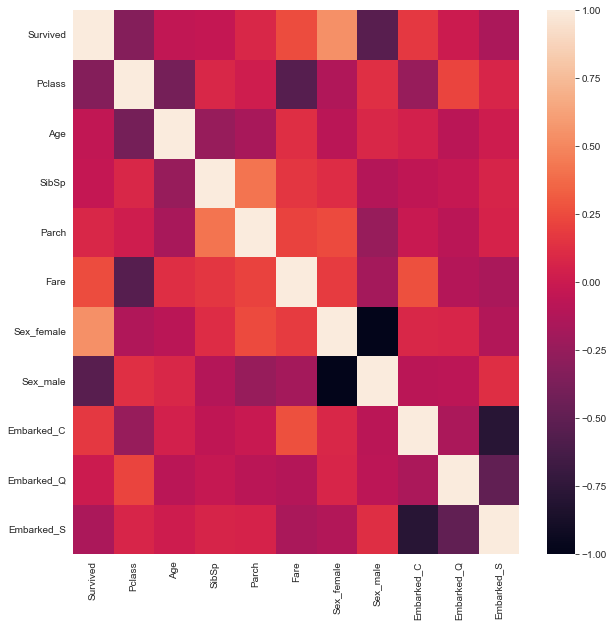

In [451]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train.drop("PassengerId", axis=1).corr())
plt.show()

In [452]:
df_train.drop("PassengerId", axis=1).corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.335549,-0.052051,-0.034040,0.083151,0.255290,0.541585,-0.541585,0.169966,0.004536,-0.151777
Pclass,-0.335549,1.000000,-0.405549,0.081656,0.016824,-0.548193,-0.127741,0.127741,-0.245733,0.220558,0.076466
Age,-0.052051,-0.405549,1.000000,-0.242807,-0.170089,0.120938,-0.083730,0.083730,0.042585,-0.080875,0.013598
SibSp,-0.034040,0.081656,-0.242807,1.000000,0.414542,0.160887,0.116348,-0.116348,-0.060074,-0.026692,0.069438
Parch,0.083151,0.016824,-0.170089,0.414542,1.000000,0.217532,0.247508,-0.247508,-0.011588,-0.081585,0.061512
Fare,0.255290,-0.548193,0.120938,0.160887,0.217532,1.000000,0.179958,-0.179958,0.270731,-0.116684,-0.163758
Sex_female,0.541585,-0.127741,-0.083730,0.116348,0.247508,0.179958,1.000000,-1.000000,0.084520,0.075217,-0.121405
Sex_male,-0.541585,0.127741,0.083730,-0.116348,-0.247508,-0.179958,-1.000000,1.000000,-0.084520,-0.075217,0.121405
Embarked_C,0.169966,-0.245733,0.042585,-0.060074,-0.011588,0.270731,0.084520,-0.084520,1.000000,-0.148646,-0.782613
Embarked_Q,0.004536,0.220558,-0.080875,-0.026692,-0.081585,-0.116684,0.075217,-0.075217,-0.148646,1.000000,-0.499261


Now i delete unnecessary features, create new feature and normalize "Fare"

In [453]:
for df in [df_train, df_test]:
    df["Relatives"] = df["Parch"] + df["SibSp"]
    df["Fare"] = preprocessing.normalize([df["Fare"]])[0][:]
    df.drop(columns=["Age", "SibSp", "Parch", "Sex_male"], inplace=True)

df_train.head()

,PassengerId,Survived,Pclass,Fare,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Relatives
0,1,0,3,0.004112,0,0,0,1,1
1,2,1,1,0.040427,1,1,0,0,1
2,3,1,3,0.004495,1,0,0,1,0
3,4,1,1,0.030115,1,0,0,1,1
4,5,0,3,0.004565,0,0,0,1,0


### 3. Model Building

#### 3.1 Splitting Dataset

In [454]:
X_train = df_train.drop(["Survived", "PassengerId"], axis=1)
y_train = df_train.Survived

X_test = df_test.drop("PassengerId", axis=1)

#### 3.2 Selecting Best Model

In [455]:
classifiers = {
    "Logistic Regression" : LogisticRegression(),
    "Naive Bayes" : MultinomialNB(),
    "SVM" : SVM(),
    "KNN" : KNeighborsClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "GB Classifier" : GradientBoostingClassifier(),
    "XGB Classifier" : XGBClassifier()
}

results = pd.DataFrame(columns=["Classifier", "AVG_F1"])
for name, clf in classifiers.items():
    model = clf
    CV_results = cross_validate(
        model, X_train, y_train,
        cv=10, scoring=(["f1"])
    )

    results = results.append({
        "Classifier" : name,
        "AVG_F1": CV_results['test_f1'].mean()
    }, ignore_index=True)

results = results.sort_values("AVG_F1", ascending=False)
results.reset_index(drop=True)

/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_48047/2583408708.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_48047/2583408708.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_48047/2583408708.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_48047/2583408708.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk

,Classifier,AVG_F1
0,XGB Classifier,0.743332
1,GB Classifier,0.739011
2,Random Forest,0.727552
3,SVM,0.72659
4,KNN,0.716498
5,Logistic Regression,0.713594
6,Naive Bayes,0.704467


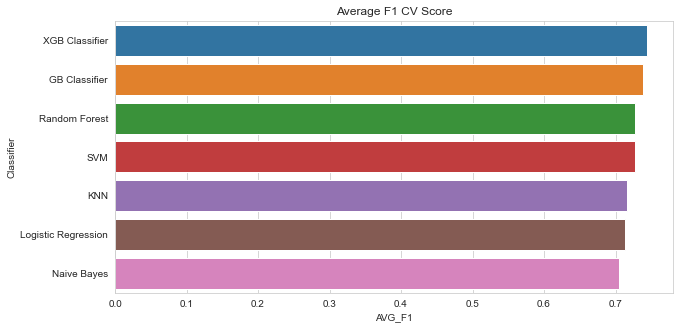

In [456]:
plt.figure(figsize=(10,5))
sns.barplot(data=results, x="AVG_F1", y="Classifier")
plt.title("Average F1 CV Score")
plt.show()

As we can see from the cross validation test above, XGB and GB classifiers did the best job. Let's tune their hyperparameters using Grid Search Cross Validation.

#### 3.3 Hyperparameter Tuning

##### XGB Classifier

In [457]:
XGB = XGBClassifier(random_state = 0)

params = {
    "max_depth" : (3, 6, 9),
    "learning_rate" : (0.3, 0.1, 0.05),
    "n_estimators" : (50, 75, 100, 150, 200)

}

clf1 = GridSearchCV(XGB, params, cv=10)
clf1.fit(X_train, y_train)
print("Best hyperparameters:", clf1.best_params_)

Best hyperparameters: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 75}


In [458]:
y_pred = clf1.predict(X_train)

print(f"Train accuracy for XGB: {accuracy_score(y_train, y_pred)}")

Train accuracy for XGB: 0.906636670416198


##### GB classifier

In [459]:
GB = GradientBoostingClassifier(random_state = 0)

params = {
    "max_depth" : (3, 6, 9),
    "learning_rate" : (0.3,  0.1, 0.05),
    "n_estimators" : (50, 75, 100, 150, 200),
    "ccp_alpha" : (0, 0.01, 0.1)

}

clf2 = GridSearchCV(GB, params, cv=10)
clf2.fit(X_train, y_train)

print("Best hyperparameters for GB:", clf2.best_params_)

Best hyperparameters for GB: {'ccp_alpha': 0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 75}


In [460]:
y_pred = clf2.predict(X_train)

print(f"Train accuracy for GB: {accuracy_score(y_train, y_pred)}")

Train accuracy for GB: 0.8987626546681665


XGB showed a little bit better, so let's choose it as our final model

### Making Submission

In [464]:
y_pred = clf1.predict(X_test)

submission = pd.DataFrame({
    "PassengerId" : df_test.PassengerId,
    "Survived" : y_pred
})

submission.to_csv("submission.csv", index=False)